In [2]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
keras = tf.keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib inline

from src.time_series_functions import *

Using TensorFlow backend.


In [3]:
print(keras.__version__)
##may need to update keras

2.2.4-tf


In [4]:
base_df = csv_with_datetime('data/combdf_snoflow_and_cfs1.csv', 'Unnamed: 0')
df = base_df.copy()

In [5]:
#small % of records containing NaNs in the temp columns, randomly distributed. using ffill. 
df.fillna(method='ffill', inplace=True)

In [6]:
df = df[['ds', 'Streamflow Value', 'Air Temperature Average (degF)',\
                'Precipitation Accumulation (in) Start of Day Values',\
                'Snow Water Equivalent (in) Start of Day Values']]

In [7]:
df.columns = ['ds', 'y', 'avg_temp', 'precip_accum', 'swe']

In [8]:
#cleaning the dataframe to end at 12/31/2020 for cleaner working frame

In [9]:
df = df['1990':'2020']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1990-01-01 to 2020-12-31
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            11323 non-null  datetime64[ns]
 1   y             11323 non-null  float64       
 2   avg_temp      11323 non-null  float64       
 3   precip_accum  11323 non-null  float64       
 4   swe           11323 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 530.8 KB


In [11]:
#we now have a full 31 year dataframe (01/01/1990 - 12/31/2020), no nans, and columns appropriately named
#granularity of the data is daily, writing code based on day count not calendar year for OOP

In [12]:
test_size = 365

In [13]:
#slice the training data to all years but final year
train = df.iloc[:-test_size,:].copy()
#slice the test data to final year
test = df.iloc[-test_size: , : ].copy()

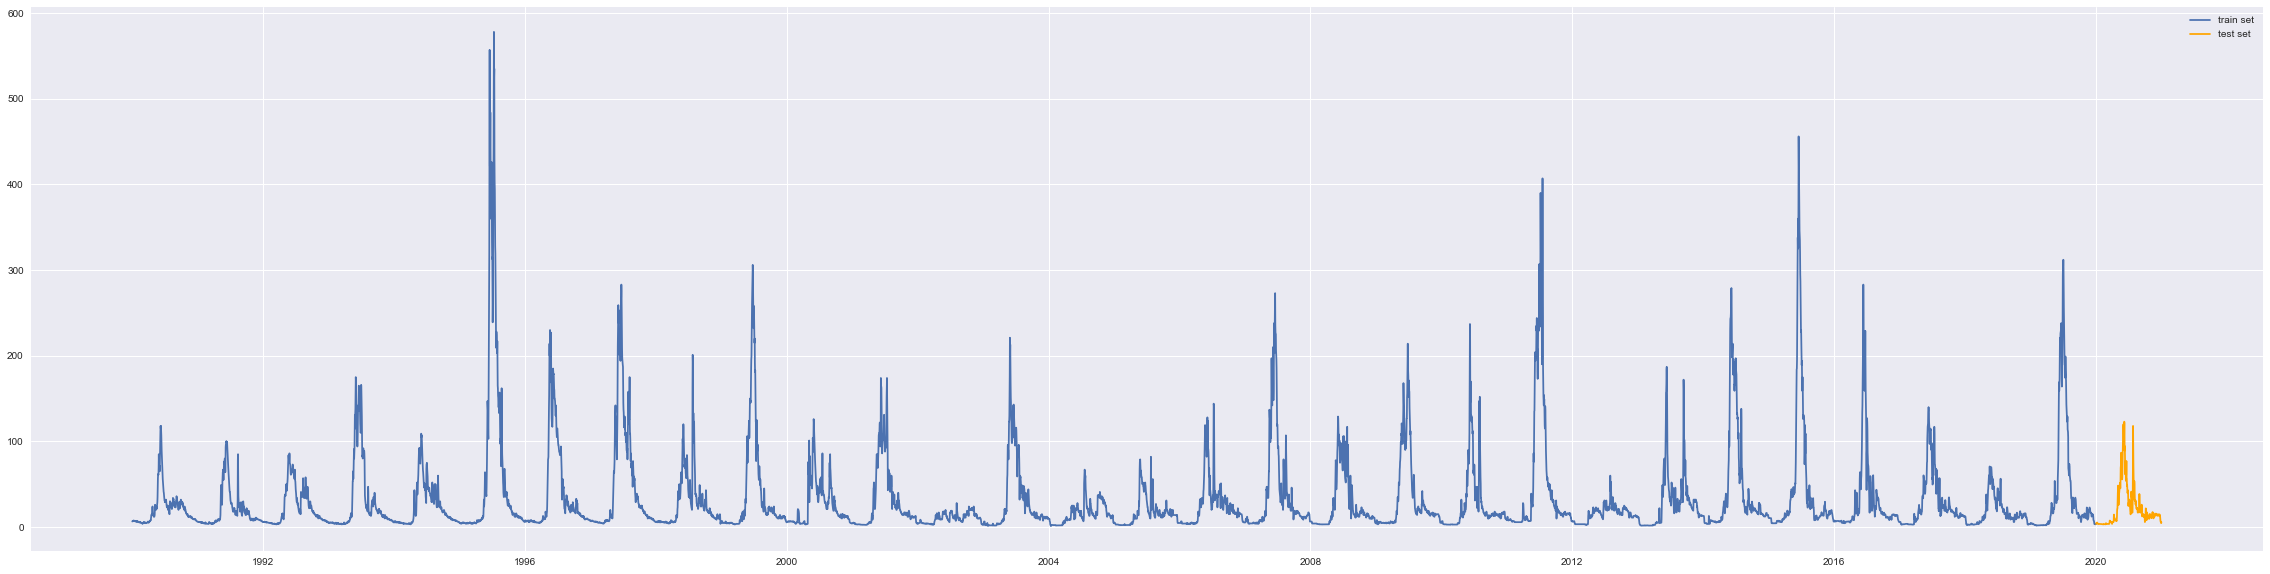

In [14]:
plt.figure(figsize=(40,10))
plt.plot(train.index,train['y'],label='train set');
plt.plot(test.index,test['y'],label='test set', color='orange')
plt.legend();

In [15]:
#definitely out of proportion for normal train/test.  Prophet model did best passing only 20 years of training data
#will try different sizes of training data on LSTM to find optimal training set

In [18]:
#splitting training data into X_train and y_train, still dataframes maintaining their datetime index
X_train = train.drop(columns='y')
y_train = pd.DataFrame(train['y'])
X_test = test.drop(columns='y')
y_test = pd.DataFrame(train['y'])

In [39]:
samp_df = df.iloc[:10, :].copy()
samp_df.head()

,ds,y,avg_temp,precip_accum,swe
Unnamed: 0,,,,,
1990-01-01,1990-01-01,6.5,19.0,5.6,4.8
1990-01-02,1990-01-02,6.9,16.0,5.7,4.8
1990-01-03,1990-01-03,6.9,2.0,5.7,4.8
1990-01-04,1990-01-04,6.8,-2.0,5.7,4.8
1990-01-05,1990-01-05,7.3,1.0,5.7,4.8


In [26]:
#starting the split over using windowize function, three dimensional output for X_train and X_test
#the below windowize functions are imported but pasted here for working through setup
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

def split_and_windowize(data, n_prev, n_test=365):
    n_predictions = len(data) - 2*n_prev
    
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    
    return x_train, x_test, y_train, y_test

In [40]:
windowize_data(samp_df, 5)

TypeError: '(array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8]]), None)' is an invalid key

In [28]:
x_train, x_test, y_train, y_test = split_and_windowize(df.to_numpy(), 50, 365)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10808, 50, 1, 5), (415, 50, 1, 5), (10808, 5), (415, 5))

In [33]:
n_prev=50
model = keras.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(n_prev, 5), return_sequences=True))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mse')

In [34]:
model.fit(x_train.reshape(-1,50,5), y_train.reshape(-1,50,5), batch_size=32, epochs=10, validation_split=0.2)

ValueError: cannot reshape array of size 54040 into shape (50,5)